**Importing Libaries**

In [ ]:
# Thư viện trực quan hóa và xử lý dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set()

# Thư viện xử lý ngôn ngữ
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Thư viện xử lý file
import zipfile
from wordcloud import WordCloud
from IPython.display import display

# Thư viện học máy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from tabulate import tabulate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
# Giải nén, đọc và hiển thị dữ liệu
with zipfile.ZipFile('./Data/WELFake_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./Data/')

data = pd.read_csv("./Data/WELFake_Dataset.csv")

print(f"The shape of data: {data.shape}\n")
data.head()

The shape of data: (72134, 4)



,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [17]:
# Loại bỏ các cột không cần thiết (nếu tồn tại)
data.drop('Unnamed: 0', axis=1, inplace=True)

# Đổi tên các cột
data.rename(columns={'label': 'Label', 'title': 'Title', 'text': 'Text'}, inplace=True)

data.head()

,Title,Text,Label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [18]:
# Kiểm tra dữ liệu rỗng
data.isnull().sum()

Title    558
Text      39
Label      0
dtype: int64

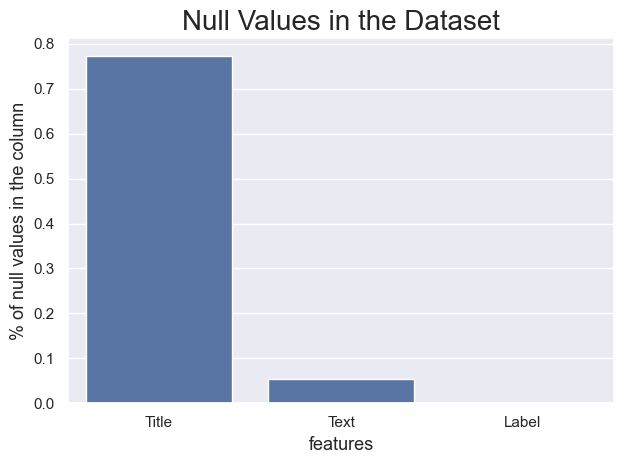

In [19]:
# Trực quan hóa tỷ lệ giá trị rỗng trong mỗi cột

def plot_nulls(data,title,x_axis_label,y_axis_label):

    data_nulls = (data.apply(lambda x:x.isnull().value_counts()).T[True]/len(data)*100).reset_index(name='count')

    sns.barplot(data_nulls,x="index",y="count")
    plt.title(title,fontsize=20)
    plt.xlabel(x_axis_label,fontsize=13)
    plt.ylabel(y_axis_label,fontsize=13)

    plt.tight_layout()
    plt.show()

plot_nulls(data,"Null Values in the Dataset",'features','% of null values in the column')

In [20]:
# Xóa các hàng chứa giá trị rỗng
data.dropna(axis = 0, inplace=True)

print(f"The shape of data after remove NaN rows: {data.shape}\n")

The shape of data after remove NaN rows: (71537, 3)



In [21]:
# Kiểm tra số lượng hàng bị trùng lặp
print(f"Number of duplicate rows: {data.duplicated().sum()}")

Number of duplicate rows: 8416


In [22]:
# Xóa các hàng trùng lặp
data.drop_duplicates(inplace=True)

print(f"The shape of data after remove duplicate rows: {data.shape}\n")

The shape of data after remove duplicate rows: (63121, 3)



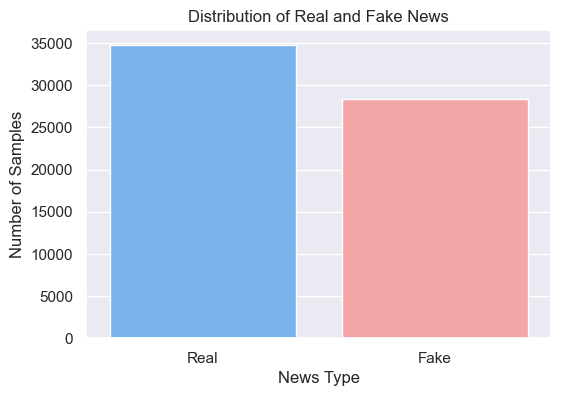

In [23]:
# Trực quan hóa phân phối các nhãn

palette = {'0': '#66b3ff', '1': '#ff9999'}

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Label', data=data, palette=palette)
plt.title('Distribution of Real and Fake News')
plt.xlabel('News Type')
plt.ylabel('Number of Samples')
ax.set_xticklabels(['Real', 'Fake'])

plt.show()

In [24]:
label_percentages = data['Label'].value_counts(normalize=True) * 100
print("Percentage of each label: (0 = Real & 1 = Fake)")
print(label_percentages)

Percentage of each label: (0 = Real & 1 = Fake)
Label
0    55.117948
1    44.882052
Name: proportion, dtype: float64


In [25]:
# Kết hợp 'Title' và 'Text'
data['combined'] = data['Title'] + ' ' + data['Text']

data = data.drop(columns=['Title', 'Text'])

data.rename(columns={'combined': 'Text'}, inplace=True)

data.sample(5)

,Label,Text
42374,0,Canadian court rules Trump can face claims in ...
31924,0,Report: Hillary Clinton Spent ’Tens of Million...
7928,1,These Banks Are Fighting The Cycle Of Poverty...
23494,1,OH THE IRONY! PLANNED PARENTHOOD USES A FAMOUS...
10485,1,CNN Anchor Asks Van Jones To Take Back His Pra...


In [26]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Xóa links khỏi văn bản
    text = re.sub(r'(http[s]?://\S+|www\.\S+|\S+\.(com|net|org))', '', text)

    # Chuyển chữ hoa thành chữ thường
    text = text.lower()

    # Loại bỏ ký tự đặc biệt và các khoảng trắng thừa
    text = re.sub(r'[^a-zA-Z\s]', '', text).strip()
    text = re.sub(r'\s+', ' ', text)

    # Lemmatization và loại bỏ từ dừng
    text = ' '.join(lemmatizer.lemmatize(word, pos='v') for word in text.split() if word not in stop_words)
    return text

data['Text'] = data['Text'].apply(clean_text)

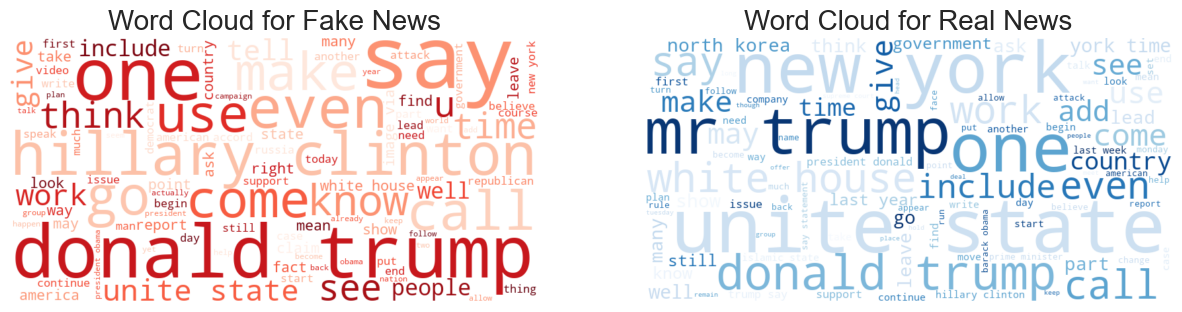

In [27]:
# Trực quan hóa văn bản tin giả và thật

fake_news = data[data['Label'] == 1]
real_news = data[data['Label'] == 0]

fake_text = ' '.join(fake_news['Text'])
real_text = ' '.join(real_news['Text'])

wordcloud_fake = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    colormap='Reds'
).generate(fake_text)

wordcloud_real = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    colormap='Blues'
).generate(real_text)

plt.figure(figsize=(15, 7))

# Word Cloud cho tin tức Fake
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Fake News', fontsize=20)

# Word Cloud cho tin tức Real
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real News', fontsize=20)

plt.show()

In [28]:
# Chia dữ liệu
X = data["Text"]
y = data["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=24
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 50496
Test set size: 12625


In [29]:
# Định nghĩa TF-IDF để chuẩn bị vector hóa văn bản
vectorizer = TfidfVectorizer(
    min_df=5,                    # Giữ lại các từ xuất hiện trong ít nhất 5 tài liệu
    max_df=0.95,                 # Loại bỏ các từ xuất hiện trong hơn 95% tài liệu
    max_features=5000,
    token_pattern=r'\b[a-zA-Z]{2,15}\b',  # Chỉ giữ các từ có từ 2 đến 15 chữ cái
    ngram_range=(1,2) )           # Sử dụng unigram và bigram

In [30]:
# Sử dụng pipeline
models = {
    "Multinomial Naive Bayes": Pipeline([
        ('tfidf', vectorizer),
        ('clf', MultinomialNB())
    ]),
    "Random Forest": Pipeline([
        ('tfidf', vectorizer),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=24, min_samples_split=5, min_samples_leaf=3, n_jobs=-1, max_depth=20, max_features='sqrt', class_weight='balanced'))
    ]),
    "Logistic Regression": Pipeline([
        ('tfidf', vectorizer),
        ('clf', LogisticRegression(C=0.1, random_state=24, max_iter=1000, solver='lbfgs', class_weight='balanced'))
    ]),
    "Linear SVM": Pipeline([
        ('tfidf', vectorizer),
        ('clf', LinearSVC(C=0.1, random_state=24, loss='squared_hinge', class_weight='balanced'))
    ])
}

In [31]:
results_train = []
results_test = []

for model_name, pipeline in models.items():
    print(f"\nTraining {model_name}...")
    pipeline.fit(X_train, y_train)

    # Dự đoán trên tập huấn luyện
    y_train_pred = pipeline.predict(X_train)
    # Đánh giá trên tập huấn luyện
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)

    results_train.append({
        'Model': model_name,
        'Accuracy': train_accuracy,
        'Precision': train_precision,
        'Recall': train_recall,
        'F1-score': train_f1
    })

    # Dự đoán trên tập kiểm tra
    y_test_pred = pipeline.predict(X_test)
    # Đánh giá trên tập kiểm tra
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    results_test.append({
        'Model': model_name,
        'Accuracy': test_accuracy,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1-score': test_f1
    })

    print(f"{model_name} - Training set:")
    print(f"Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1:.4f}")
    print(f"{model_name} - Test set:")
    print(f"Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}")

results_train_df = pd.DataFrame(results_train)
results_test_df = pd.DataFrame(results_test)

# Hiển thị kết quả
print("\n=====Training Set Results:=====\n")
print(results_train_df)

print("\n=====Test Set Results:=====\n")
print(results_test_df)


Training Multinomial Naive Bayes...
Multinomial Naive Bayes - Training set:
Accuracy: 0.8523, Precision: 0.8240, Recall: 0.8531, F1-score: 0.8383
Multinomial Naive Bayes - Test set:
Accuracy: 0.8510, Precision: 0.8209, Recall: 0.8544, F1-score: 0.8373

Training Random Forest...
Random Forest - Training set:
Accuracy: 0.9617, Precision: 0.9499, Recall: 0.9655, F1-score: 0.9576
Random Forest - Test set:
Accuracy: 0.9209, Precision: 0.9079, Recall: 0.9167, F1-score: 0.9123

Training Logistic Regression...
Logistic Regression - Training set:
Accuracy: 0.9250, Precision: 0.9061, Recall: 0.9292, F1-score: 0.9175
Logistic Regression - Test set:
Accuracy: 0.9210, Precision: 0.8972, Recall: 0.9306, F1-score: 0.9136

Training Linear SVM...
Linear SVM - Training set:
Accuracy: 0.9584, Precision: 0.9503, Recall: 0.9573, F1-score: 0.9538
Linear SVM - Test set:
Accuracy: 0.9469, Precision: 0.9338, Recall: 0.9490, F1-score: 0.9414

=====Training Set Results:=====

                     Model  Accurac

In [32]:
# Trực quan hóa confusion matrix

def plot_confusion_matrix_raw(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

model_names = ["Multinomial Naive Bayes", "Random Forest", "Logistic Regression", "Linear SVM"]

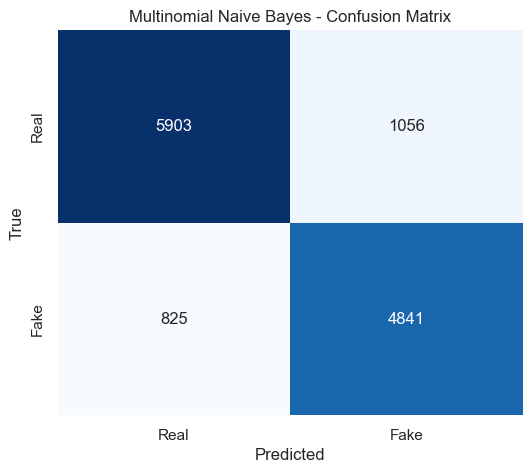

In [33]:
# Multinomial Naive Bayes
model_name = "Multinomial Naive Bayes"
pipeline = models[model_name]
y_test_pred = pipeline.predict(X_test)
plot_confusion_matrix_raw(y_test, y_test_pred, model_name)

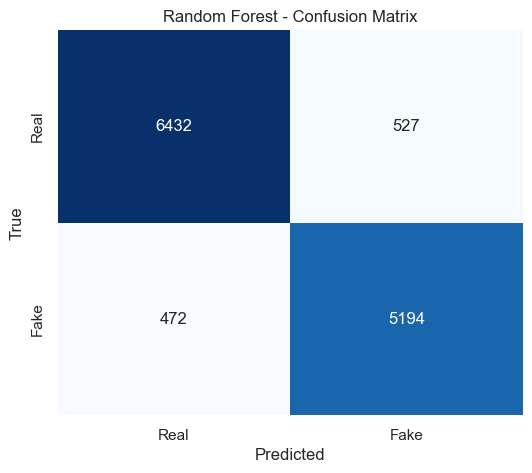

In [34]:
# Random Forest
model_name = "Random Forest"
pipeline = models[model_name]
y_test_pred = pipeline.predict(X_test)
plot_confusion_matrix_raw(y_test, y_test_pred, model_name)

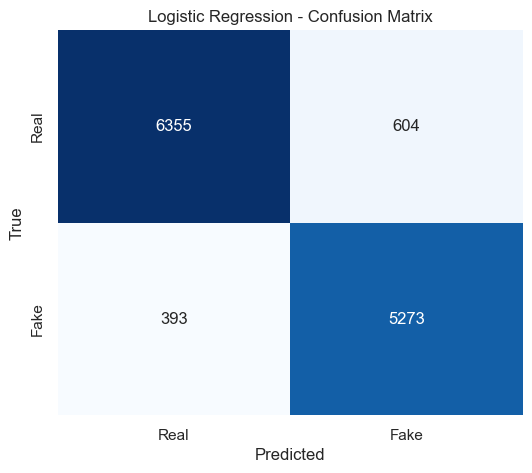

In [35]:
# Logistic Regression
model_name = "Logistic Regression"
pipeline = models[model_name]
y_test_pred = pipeline.predict(X_test)
plot_confusion_matrix_raw(y_test, y_test_pred, model_name)

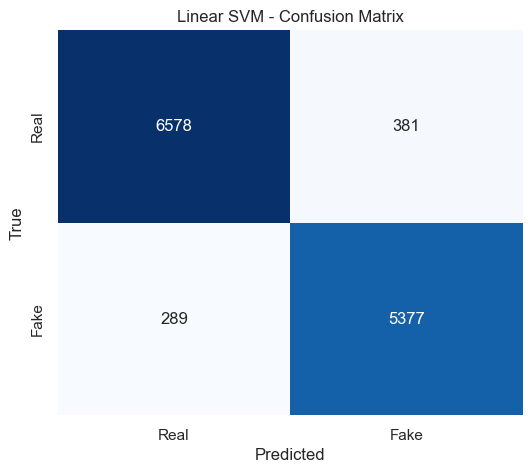

In [36]:
# Linear SVM
model_name = "Linear SVM"
pipeline = models[model_name]
y_test_pred = pipeline.predict(X_test)
plot_confusion_matrix_raw(y_test, y_test_pred, model_name)

**Model Testing**

In [37]:
def output_label(label):
    if label == 0:
        return "Real"
    elif label == 1:
        return "Fake"
    else:
        return "Unknown"
for model_name, pipeline in models.items():
    pipeline.fit(X, y)

def manual_testing(news):
    if not news:
        print("Please enter a text to test.")
        return

    testing_news = {"text": [news]}
    new_df_test = pd.DataFrame(testing_news)
    new_df_test["text"] = new_df_test["text"].apply(clean_text)

    predictions = {}
    for model_name, pipeline in models.items():
        pred = pipeline.predict(new_df_test["text"])[0]
        predictions[model_name] = output_label(pred)

    results_df = pd.DataFrame(list(predictions.items()), columns=["Model", "Result"])
    print("\nPredictions from Models:")
    display(results_df)

In [40]:
# Nhập input từ bàn phím
print("===== Fake News Detection System =====\n")
news = str(input())
print(f"Text: {news}")
manual_testing(news)

===== Fake News Detection System =====

Text: Trump’s border wall: Trump repeated his false claim that “I built over 500 miles of wall” on the southern border. Official government data shows 458 miles were built under Trump – including both wall built where no barriers had existed before and wall built to replace previous barriers.  Trump’s crowds: Trump falsely claimed of his rallies: “We never have an empty seat.” There have been empty seats at numerous Trump rallies over the years – including hundreds at this very rally in Reading. And at many Trump rallies, some once-filled seats empty out during his speeches when supporters leave.  Trump’s crowd in Butler: Trump falsely claimed there were “over 100,000 people” at the rally he held Saturday in Butler, Pennsylvania, at the same site where a gunman had attempted to assassinate him in July. CNN affiliate KDKA in Pittsburgh reported that the Secret Service put the crowd at 24,000 people, while the Trump-supporting sheriff of Blair Coun

,Model,Result
0,Multinomial Naive Bayes,Fake
1,Random Forest,Fake
2,Logistic Regression,Fake
3,Linear SVM,Fake


In [41]:
print("===== Fake News Detection System =====\n")
news = str(input())
print(f"Text: {news}")
manual_testing(news)

===== Fake News Detection System =====

Text: SAO PAULO (Reuters) - Cesar Mata Pires, the owner and co-founder of Brazilian engineering conglomerate OAS SA, one of the largest companies involved in Brazil s corruption scandal, died on Tuesday. He was 68. Mata Pires died of a heart attack while taking a morning walk in an upscale district of S o Paulo, where OAS is based, a person with direct knowledge of the matter said. Efforts to contact his family were unsuccessful. OAS declined to comment. The son of a wealthy cattle rancher in the northeastern state of Bahia, Mata Pires  links to politicians were central to the expansion of OAS, which became Brazil s No. 4 builder earlier this decade, people familiar with his career told Reuters last year. His big break came when he befriended Antonio Carlos Magalh es, a popular politician who was Bahia governor several times, and eventually married his daughter Tereza. Brazilians joked that OAS stood for  Obras Arranjadas pelo Sogro  - or  Work A

,Model,Result
0,Multinomial Naive Bayes,Real
1,Random Forest,Real
2,Logistic Regression,Real
3,Linear SVM,Real
